### To Do:
* Build Efficient Frontier Visualizations
* Figure out no short-sell constraint
* Get Risk Free Rate
* Build Fama-French Portfolio Evaluator

https://github.com/c0redumb/yahoo_quote_download

In [108]:
import pandas as pd
import datetime as dt
import requests
import json
import csv

import pandas_datareader.data as pdr
import quandl

import statsmodels.api as sm
import statsmodels.formula.api as smf

import numpy as np
from scipy.optimize import minimize


import matplotlib.pyplot as plt

%matplotlib inline

In [109]:
# Query Parameters
tickers = ['AAPL','F','TSLA','FB','GOOGL']

start = dt.datetime(2000,1,1)
end = dt.datetime.today().date()

[Alpha Vantage API documentation](https://www.alphavantage.co/documentation/)

In [135]:
alphvan_key = "4X35DPOWF8QL5X42"

url = 'https://www.alphavantage.co/query'

av_data = dict()

for ticker in tickers:
    parameters = {
        'function' : 'TIME_SERIES_DAILY_ADJUSTED',
        'symbol' : ticker,
        'apikey' : alphvan_key,
        'outputsize' : 'full',
        'datatype' : 'json'
          }

    resp = requests.get(url,params=parameters).json()

    alph_van = pd.DataFrame(resp['Time Series (Daily)']).transpose()
    alph_van.index = pd.DatetimeIndex(alph_van.index)
    av_data[ticker] = alph_van

KeyboardInterrupt: 

In [134]:
ticker = tickers[0]
av_data[ticker]

KeyError: 'GOOGL'

[Quandl API documentation](https://docs.quandl.com/docs/data-organization)

In [27]:
quandl_key = 'xyFjuLe9qtzAvnVCNpu5'
quandl.ApiConfig.api_key = quandl_key
db_code = 'WIKI/'

data = dict()

for ticker in tickers:
    data[ticker] = quandl.get(db_code+ticker,start_date=start,end_date=end)

tickers = list(data.keys())

In [133]:
def close_prices(data_dict,adj_close_key,
                 start_date=start,end_date=end,):

    """Returns adj. close prices of queried stocks"""

    data = data_dict
    dates = pd.date_range(start=start_date, end=end_date)
    prices = pd.DataFrame(index=dates)
    for ticker in data.keys():

        price_col =  pd.DataFrame(data[ticker][price_key]).rename({price_key:ticker},axis=1)

        prices = pd.merge(prices,price_col,
                         how='inner',
                         left_index=True,right_index=True)
    return prices

In [ ]:
close_prices(av_data,'')

In [5]:
d_returns = prices.pct_change().iloc[1:]

In [6]:
m_returns = prices.resample('M').first().pct_change().iloc[1:]

In [7]:
q_returns = prices.resample('Q').first().pct_change().iloc[1:]

In [8]:
normalized = prices / prices.iloc[0]

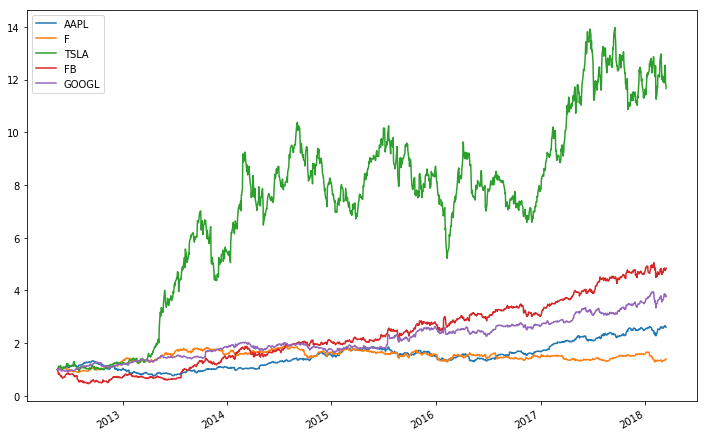

In [9]:
normalized.plot(figsize=(12,8))

In [10]:
# Set default returns series
global_returns = m_returns

In [11]:
pd.DataFrame(global_returns.var().to_dict(),index=['variance'])

,AAPL,F,FB,GOOGL,TSLA
variance,0.004503,0.004001,0.012929,0.003655,0.023421


In [12]:
def wts(weights):
    return pd.DataFrame({'weights':weights},
                        index=tickers).transpose()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b617278>]],
      dtype=object)

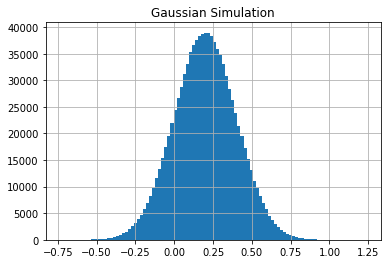

In [13]:
# Detour: Random Portfolio Simulation
import random

weights = list()

start = 0
end = 1000000
n = start

sigma = .1

for n in range(end):
    wt0 = [random.gauss(1/len(tickers),sigma)
            for n in range(len(tickers)-1)]
    weights.append(1-sum(wt0))
    
res = pd.DataFrame({'Gaussian Simulation':weights},
             index = range(len(weights)))
res.hist(bins=100)

In [14]:
wts(weights[0])

,AAPL,F,TSLA,FB,GOOGL
weights,0.484125,0.484125,0.484125,0.484125,0.484125


In [15]:
def get_portfolio(weights,data=global_returns,
              param='sharpe_ratio',opt=False):

    port = pd.DataFrame({'weights':weights},
                        index=tickers).transpose()

    cov = data.cov()

    partials = port.dot(cov)*port
    partials.rename({'weights':'Partials'},
                    axis = 0,inplace=True)

    port_var = partials.sum(axis=1)[0]

    port_std = np.sqrt(port_var)

    port_return = (data.mean()*port).sum(axis=1)[0]

    sharpe_ratio = port_return/port_std
    
    
    param = param[:2].lower()
    
    if param not in ['sh','sr','va','re','st','we']:
        new_param = input("""Choose param options:\n
        sharpe_ratio,\n
        variance,\n
        standard_deviation,\n
        returns,or\n
        weights\n""")
        
        param = new_param[:2].lower()
    if param in ['sh', 'sr']:
        if opt==False:
            return sharpe_ratio
        elif opt==True:
            return -sharpe_ratio
        
    elif param == 'va':
        return port_var
    
    elif param == 're':
        if opt==False:
            return port_return
        elif opt==True:
            return -port_return
        
    elif param == 'st':
        return port_std
    
    elif param =='we':
        return port
    else:
        print('PORTFOLIO PARAMETER ERROR')

In [16]:
def portfolio_optimize(weights,objective,data):
    return get_portfolio(weights,param=objective,opt=True,data=data)

In [17]:
def optimize(objective='sharpe_ratio',no_short=True,data=global_returns):
    
    cons = [{'type':'eq',
            'fun':lambda x: np.array(sum(x)-1)}]

    if no_short == True:
        for i in range(len(tickers)):
            cons.append({'type':'ineq',
                         'fun':lambda x: np.array(x[i])})
        
    x0 = np.array([1/len(tickers) for n in range(len(tickers))])

    res= minimize(portfolio_optimize, x0, args=(objective,data),
                  method='SLSQP',
                  constraints=cons,
                  options={'disp': False})
    return res.x

In [20]:
def port_returns(data=global_returns, output_wts = False,
                 opt_obj='sharpe ratio',no_short=True):

    port_res = get_portfolio(optimize(objective=opt_obj,
                                      data=data,
                                      no_short=no_short),
                             param='weights', data=data)

    port_returns = data*port_res.loc['weights']
    port_returns['pf'] = port_returns.sum(axis=1)
    
    if output_wts == False:
        return port_returns
    elif output_wts == True:
        return port_returns, port_res

In [23]:
port_returns(output_wts=True)[0].head()

,AAPL,F,TSLA,FB,GOOGL,pf
2012-06-30,0.015214,-0.000120,0.003702,-0.034480,-0.021999,-0.037683
2012-07-31,0.014816,0.000786,0.013822,0.013803,0.007462,0.050689
2012-08-31,0.006358,0.000174,-0.023607,-0.040310,0.040380,-0.017006
2012-09-30,0.030862,-0.000261,0.012451,-0.018925,0.034316,0.058443
2012-10-31,-0.006085,-0.000602,0.006268,0.030140,0.053224,0.082946
